## Ноутбук с симуляцией ATL

Импорты:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image, ImageDraw
from pyffs import ffsn, iffsn, ffs_shift

import pint
u = pint.UnitRegistry()

In [130]:
# a = np.array([[[1, 2, 3, 4], [5, 6, 7, 8], [1, 2, 3, 4], [5, 6, 7, 8]]])
a = np.random.rand(2, 4, 4)
T = [1, 1]
T_c = [0, 0]
N_FS = [3, 3]
f1 = iffsn(a, T, T_c, N_FS, axes=[1, 2])
f2 = []
for i in range(2):
    f2.append(iffsn(a[i], T, T_c, N_FS))
f2 = np.array(f2)
(f2 == f1).all()

True

### Функция, считающая картину на определенном расстоянии по фотке маски

пока что только для монохроматического пучка (просто саморепродукция)

In [138]:
def my_matmul(a, m):
    if np.isscalar(a):
        return a * m
    else:
        return np.outer(a, m).reshape(len(a), m.shape[0], m.shape[1])
    
def compute_carpet(mask, wavelength, T_x, T_y, z):
    '''
    Функция для вычисления дифракционной картины ATL
    param mask: изображение маски,
    param period: период маски, [ед.], 
    param wavelength: длина волны, [ед.]
    param z: расстояние от картины до маски, [1000 * ед.]

    return: изображение картины
    '''

    mask_array = np.sqrt(np.array(mask))
    print(mask_array.shape)

    T = [float(T_x / u.mm), float(T_y / u.mm)]
    T_c = [0, 0]
    N_FS = [9, 9]
    
    F = ffs_shift(ffsn(mask_array, T, T_c, N_FS))
    f_x = np.reshape(np.arange(F.shape[0]) / T[0], (1, -1))
    f_y = np.reshape(np.arange(F.shape[1]) / T[1], (-1, 1))

    z = float(z / u.mm)
    wavelength = np.array(wavelength / u.mm)

    H = np.exp(-1j * np.pi * z * my_matmul(wavelength, (np.power(f_x, 2) + np.power(f_y, 2))))
    n_wl = len(wavelength)
    result_array = iffsn(F * H, T, T_c, N_FS, axes=[1, 2])
    return np.square(np.absolute(result_array))

### Удобные функции для визуализации результата

In [73]:
def periodic_image(arr, reps):
    pic = np.tile(arr, (reps, reps))
    return Image.fromarray(pic)

def frame_plot(arr, wl, T_x, T_y, z):
    plt.figure(figsize=(6, 6))
    rectX = np.linspace(0, T_x, arr.shape[0])
    rectY = np.linspace(0, T_y, arr.shape[1])
    x, y = np.meshgrid(rectX, rectY)
    plt.pcolormesh(x, y, arr)
    plt.title(f'$\lambda = {wl}$, $z = {z}$')
    plt.xlabel(f'x, {T_x.units}')
    plt.ylabel(f'y, {T_y.units}')
    plt.show()

Пробуем функцию на примере кружка

(512, 512)


C:\Users\ACER\AppData\Local\Temp\ipykernel_16528\3332383792.py:30: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  wavelength = np.array(wavelength / u.mm)


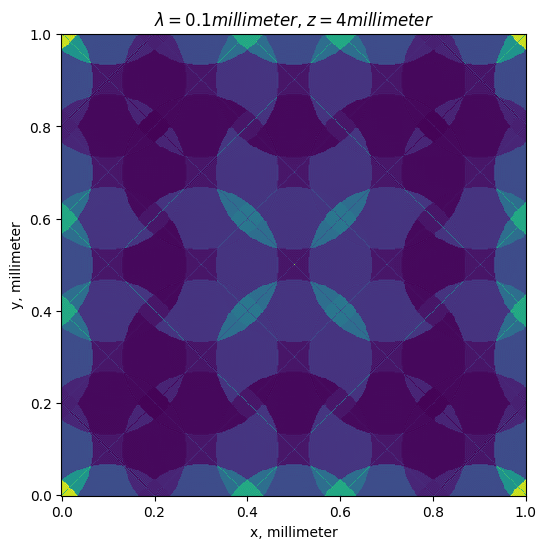

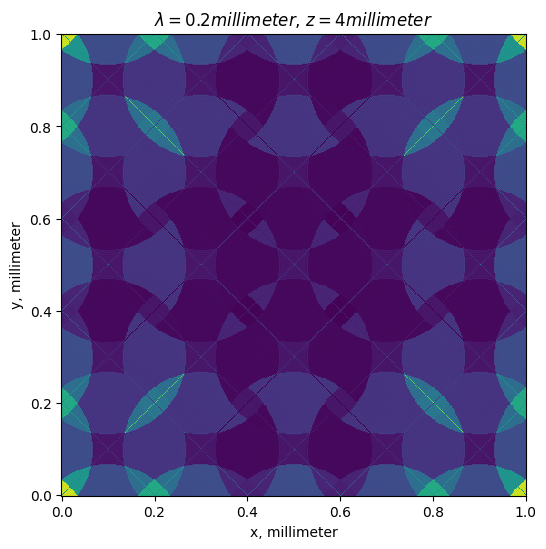

In [140]:
mask = Image.open("fig.png").convert("L")
period = 1 * u.mm
wavelength = np.array([0.1, 0.2]) * u.mm
z = 4 * u.mm
result = compute_carpet(mask, wavelength, period, period, z)
frame_plot(result[0], wavelength[0], period, period, z)
frame_plot(result[1], wavelength[1], period, period, z)
# periodic_image(result, 5).show()